# TP7 : Introduction à graphframes

Spark contient le module GraphX qui est accessible via java et scala mais pas en python.

Il existe un module tiers dénommer graphframes et qui utilise les dataframes.


Configuration des GraphFrames

Veuillez suivre les étapes ci-dessous pour importer le module -

Télécharger de https://spark-packages.org/package/graphframes/graphframes

(les versions de spark et scala utilisées sont indiquées dans les noms des fichiers)



graphframes-0.8.3-spark3.5-s_2.13.zip

graphframes-0.8.3-spark3.4-s_2.12.jar



Copiez le fichier graphframes-0.8.3-spark3.x-s_2.13.jar dans ...\spark\jars

Ce tp est inspiré de : 

https://blog.devgenius.io/graph-modeling-in-pyspark-using-graphframes-part-1-e7cb42099182

- 2 autres parties.

https://blog.devgenius.io/graph-modeling-in-pyspark-using-graphframes-part-2-26645ccd4ae7

https://blog.devgenius.io/graph-modeling-in-pyspark-using-graphframes-part-3-finding-paths-2fdd74920f1b

- Installation du package networkxx

https://networkx.org

    - utiliser afin de dessiner les graphes (peut définir des sommets, des arcs,...)

pip install networkx[default]

In [1]:
import os
import sys
import glob
from os.path import abspath

import findspark
findspark.init()
findspark.find()
from pyspark.sql import SparkSession

# configuration intégrant le package graphframes
#spark = SparkSession.builder.appName("TP7 : graphframes").\
#config("spark.jars.packages", "graphframes:graphframes:0.8.3-spark3.5-s_2.13").\
#getOrCreate()
spark = SparkSession.builder.appName("TP7 : graphframes").\
config("spark.jars.packages", "graphframes:graphframes:0.8.3-spark3.4-s_2.12").\
getOrCreate()

configurations = spark.sparkContext.getConf().getAll()
for conf in configurations:
    print(conf)

from graphframes import *

import networkx as nx
import matplotlib.pyplot as plt


sc =spark.sparkContext

sc

23/11/17 11:40:29 WARN Utils: Your hostname, MacBook-Pro-7.local resolves to a loopback address: 127.0.0.1; using 10.129.37.29 instead (on interface en0)
23/11/17 11:40:29 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/opt/spark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/laurentlecornu/.ivy2/cache
The jars for the packages stored in: /Users/laurentlecornu/.ivy2/jars
graphframes#graphframes added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-7c3732fe-1739-4638-8069-777df06de96b;1.0
	confs: [default]
	found graphframes#graphframes;0.8.3-spark3.4-s_2.12 in spark-packages
	found org.slf4j#slf4j-api;1.7.16 in spark-list
:: resolution report :: resolve 219ms :: artifacts dl 25ms
	:: modules in use:
	graphframes#graphframes;0.8.3-spark3.4-s_2.12 from spark-packages in [default]
	org.slf4j#slf4j-api;1.7.16 from spark-list in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	--------

('spark.submit.pyFiles', '/Users/laurentlecornu/.ivy2/jars/graphframes_graphframes-0.8.3-spark3.4-s_2.12.jar,/Users/laurentlecornu/.ivy2/jars/org.slf4j_slf4j-api-1.7.16.jar')
('spark.app.name', 'TP7 : graphframes')
('spark.jars', 'file:///Users/laurentlecornu/.ivy2/jars/graphframes_graphframes-0.8.3-spark3.4-s_2.12.jar,file:///Users/laurentlecornu/.ivy2/jars/org.slf4j_slf4j-api-1.7.16.jar')
('spark.app.id', 'local-1700217632587')
('spark.driver.host', '10.129.37.29')
('spark.driver.port', '56734')
('spark.app.startTime', '1700217631538')
('spark.jars.packages', 'graphframes:graphframes:0.8.3-spark3.4-s_2.12')
('spark.executor.id', 'driver')
('spark.driver.extraJavaOptions', '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=ja

<SparkContext master=local[*] appName=TP7 : graphframes>

In [2]:
# Define vertices
vertices = spark.createDataFrame([
    ("Alice", 45),
    ("Jacob", 43),
    ("Roy", 21),
    ("Ryan", 49),
    ("Emily", 24),
    ("Sheldon", 52)],
    ["id", "age"]
)

# Define edges 
edges = spark.createDataFrame([("Sheldon", "Alice", "Sister"),
                              ("Alice", "Jacob", "Husband"),
                              ("Emily", "Jacob", "Father"),
                              ("Ryan", "Alice", "Friend"),
                              ("Alice", "Emily", "Daughter"),
                              ("Alice", "Roy", "Son"),
                              ("Jacob", "Roy", "Son")],
                             ["src", "dst", "relation"])
vertices.show()
edges.show()

+-------+---+
|     id|age|
+-------+---+
|  Alice| 45|
|  Jacob| 43|
|    Roy| 21|
|   Ryan| 49|
|  Emily| 24|
|Sheldon| 52|
+-------+---+

+-------+-----+--------+
|    src|  dst|relation|
+-------+-----+--------+
|Sheldon|Alice|  Sister|
|  Alice|Jacob| Husband|
|  Emily|Jacob|  Father|
|   Ryan|Alice|  Friend|
|  Alice|Emily|Daughter|
|  Alice|  Roy|     Son|
|  Jacob|  Roy|     Son|
+-------+-----+--------+



In [3]:
family_tree = GraphFrame(vertices, edges)

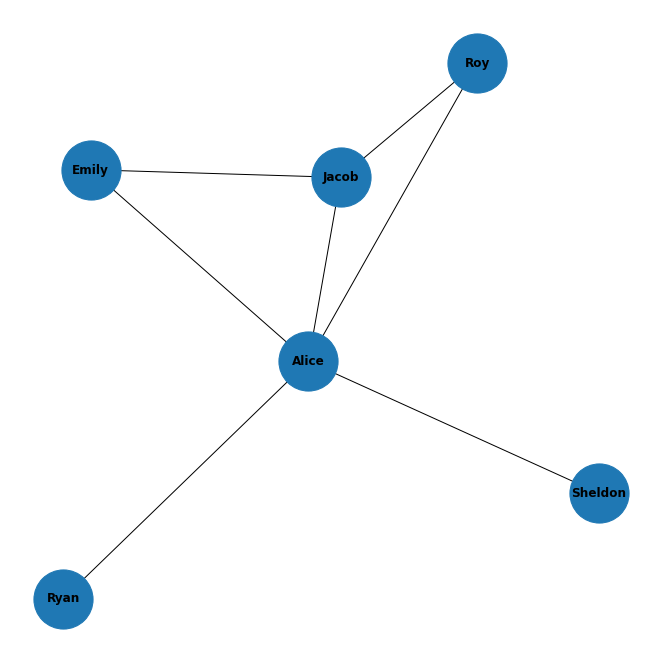

In [4]:
# the function will plot the source and destination nodes and connect them by meand of undirected line
def plot_undirected_graph(edge_list):
    # edge list contains infor,ation about edges which have clear direction
    # hoowever we will diregard the the direction in this function
    # the first thing is to plot the figure
    plt.figure(figsize=(9,9))
    # we instantiate a networkx graoh object.
    # nx. graoh represents an undirected graph.
    gplot=nx.Graph()
    for row in edge_list.select("src", "dst").take(1000):
        gplot.add_edge(row["src"], row["dst"])
    nx.draw(gplot, with_labels=True, font_weight="bold", node_size=3500)
    
    
plot_undirected_graph(family_tree.edges)

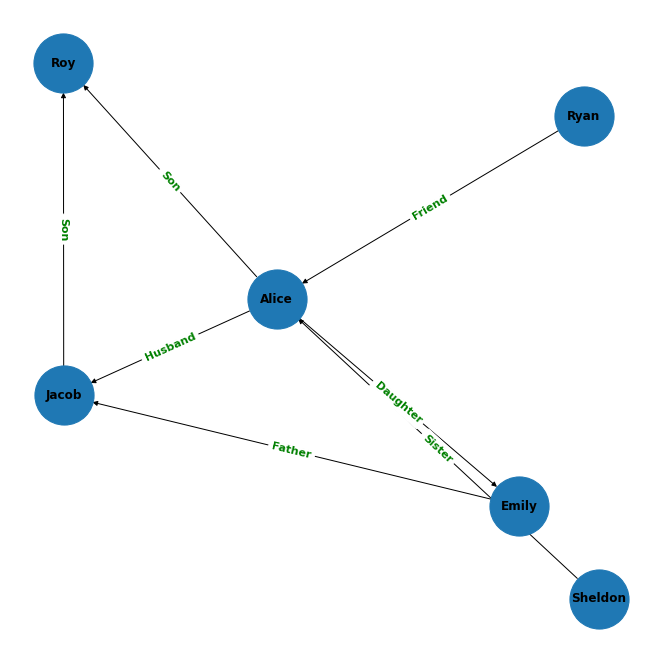

In [5]:
# the function will plot the source and destination nodes and connect them by meand of undirected line
def plot_directed_graph(edge_list):
    plt.figure(figsize=(9,9))
    gplot=nx.DiGraph()
    edge_labels = {}
    for row in edge_list.select("src", "dst", "relation").take(1000):
        gplot.add_edge(row["src"], row["dst"])
        edge_labels[(row["src"], row["dst"])] = row["relation"]
    pos = nx.spring_layout(gplot)
    nx.draw(gplot, pos, with_labels=True, font_weight="bold", node_size=3500)
    nx.draw_networkx_edge_labels(gplot, pos, edge_labels=edge_labels, font_color="green", font_size=11, font_weight="bold")

plot_directed_graph(family_tree.edges)

In [6]:
tree_degree = family_tree.degrees

tree_degree.show()

+-------+------+
|     id|degree|
+-------+------+
|Sheldon|     1|
|  Alice|     5|
|  Jacob|     3|
|  Emily|     2|
|   Ryan|     1|
|    Roy|     2|
+-------+------+



In [7]:
degree_edges = edges.filter(("src = 'Alice' or dst = 'Alice'"))

degree_edges.show()

+-------+-----+--------+
|    src|  dst|relation|
+-------+-----+--------+
|Sheldon|Alice|  Sister|
|  Alice|Jacob| Husband|
|   Ryan|Alice|  Friend|
|  Alice|Emily|Daughter|
|  Alice|  Roy|     Son|
+-------+-----+--------+



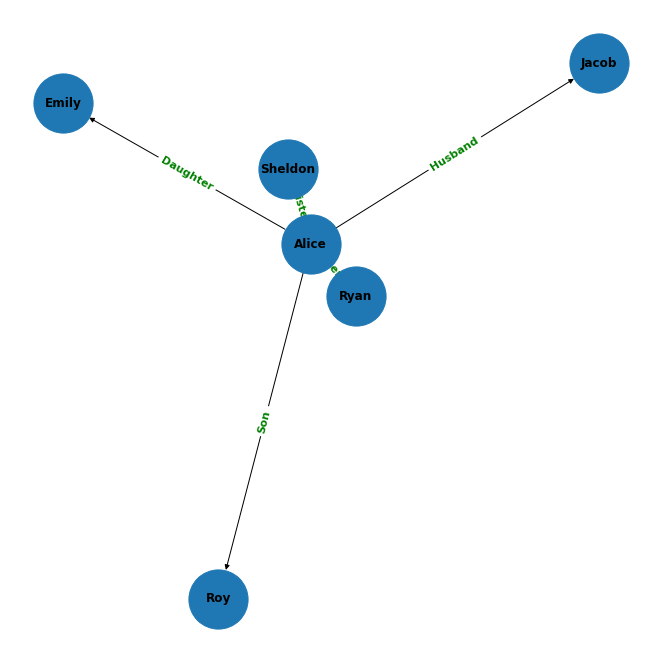

In [8]:
plot_directed_graph(degree_edges)

In [9]:
tree_inDegree = family_tree.inDegrees
tree_inDegree.show()

+-----+--------+
|   id|inDegree|
+-----+--------+
|Alice|       2|
|Jacob|       2|
|Emily|       1|
|  Roy|       2|
+-----+--------+



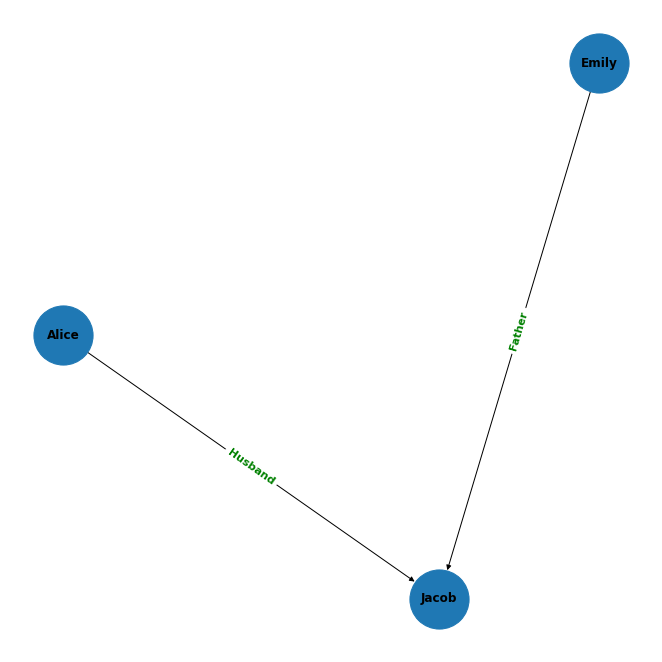

In [10]:
indegree_edges = edges.filter(("dst = 'Jacob'"))
plot_directed_graph(indegree_edges)

In [11]:
tree_outDegree = family_tree.outDegrees
tree_outDegree.show()

+-------+---------+
|     id|outDegree|
+-------+---------+
|Sheldon|        1|
|  Emily|        1|
|  Alice|        3|
|   Ryan|        1|
|  Jacob|        1|
+-------+---------+

